# Multi-Class Obesity Prediction

## Import Necessary Libraries to Run Notebook

In [34]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV,RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler

## Import Datasets and Perform General Check

In [35]:
train = pd.read_csv('C:/Users/New/GitProjects/MyProjects/Predicting-Obesity-Levels/project_files/train.csv')
test = pd.read_csv('C:/Users/New/GitProjects/MyProjects/Predicting-Obesity-Levels/project_files/test.csv')
print(f"The train dataset has {train.shape[0]} rows and {train.shape[1]} columns")
print(f"The test dataset has {test.shape[0]} rows and {test.shape[1]} columns")

The train dataset has 20758 rows and 18 columns
The test dataset has 13840 rows and 17 columns


In [36]:
# Check Datasets for Missing Values 
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20758 non-null  int64  
 1   Gender                          20758 non-null  object 
 2   Age                             20758 non-null  float64
 3   Height                          20758 non-null  float64
 4   Weight                          20758 non-null  float64
 5   family_history_with_overweight  20758 non-null  object 
 6   FAVC                            20758 non-null  object 
 7   FCVC                            20758 non-null  float64
 8   NCP                             20758 non-null  float64
 9   CAEC                            20758 non-null  object 
 10  SMOKE                           20758 non-null  object 
 11  CH2O                            20758 non-null  float64
 12  SCC                             

## Simple Visualizations of Dataset

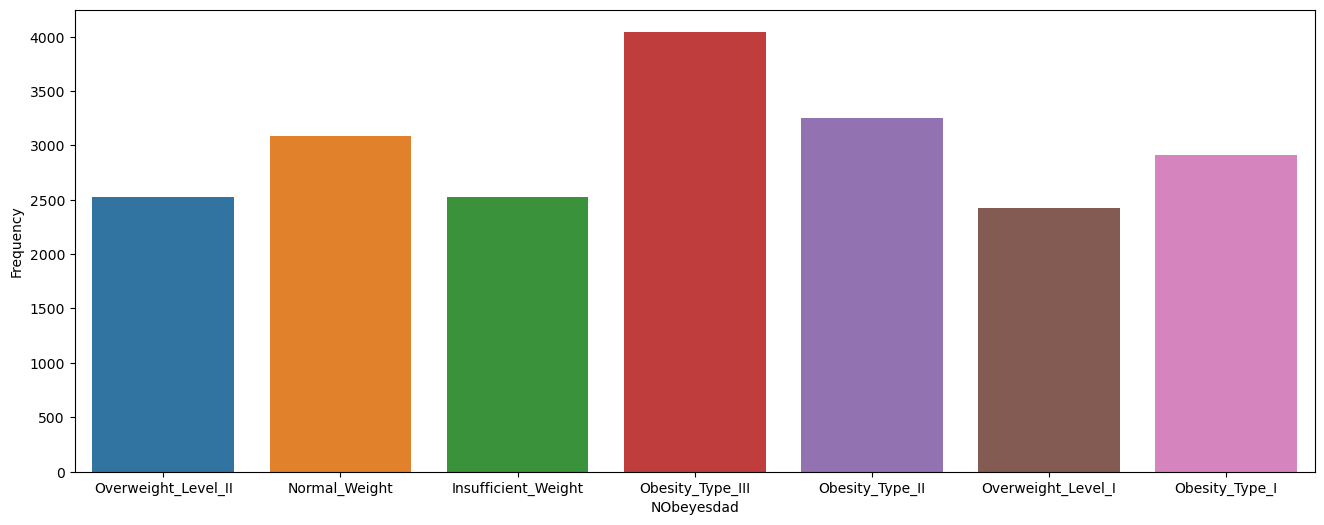

In [37]:
# Visualize the Distribution of the Target in Train Dataset
plt.figure(figsize=(16, 6)) 
sns.countplot(data = train, x = 'NObeyesdad')
plt.ylabel('Frequency');

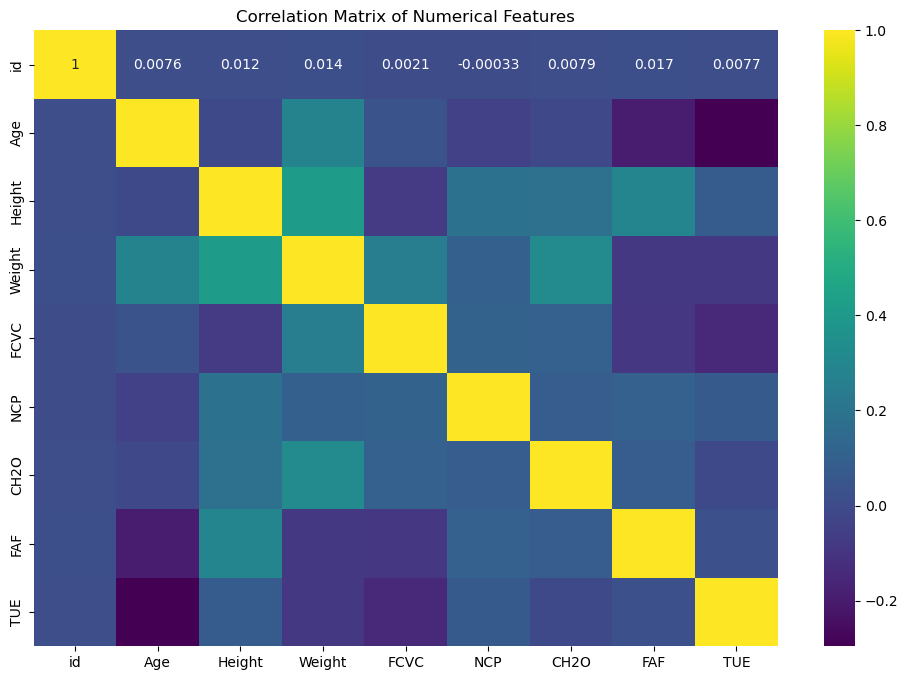

In [38]:
# Correlation of Numeric Features
num_cols = list(train.select_dtypes(exclude=['object']).columns)
corr_matrix = train[num_cols].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='viridis')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

## Feature Engineering and Data Pre-Processing

In [39]:
# Create cat_bmi Function to Make BMI Categories
def cat_bmi(bmi):
    if bmi < 18.5:
        return "Underweight"
    elif 18.5 <= bmi < 25:
        return "Healthy weight"
    elif 25 <= bmi < 30:
        return "Overweight"
    elif bmi >= 30:
        return "Obese"

# Create Feature Wrangling Function
def feat_trans(df):
    
    # Create New BMI and BMI Category from Height and Weight
    df['BMI'] = df['Weight'] / (df['Height'] ** 2)
    df['BMI_Cat'] = df['BMI'].apply(cat_bmi) 
    
    # Feature Engineering Based on the Data Dictionary
    # First Convert Float Datatypes into Int, Except Height and Weight that are actually Floats according to the Data Dictionary
    ignore_floats = ['Height', 'Weight']
    for col in df.drop(columns=ignore_floats, axis=1).columns:
        if df[col].dtypes == 'float64':
             df[col] = df[col].astype(int)

    # Convert the Integers for the Transformed Variables except AGE into Categories According to the Data Dictionary
    # Create Dictionaries to Map the Variable Elements
    cat_fvcv = {1:"Never", 2: "Sometimes", 3 :"Always"}
    cat_ch2o = {1: "Less_than_1L", 2: "Between_1_and_2L", 3: "More_than_2L"}
    cat_faf = {0: "I_do_not", 1: "One_or_Two_Days", 2: "Two_or_Four_Days", 3: "Four_or_Five_Days"}
    cat_tue = {0: "Zero_to_Two_Hours", 1: "Between_Three_and_Five_Hours", 2: "More_than_Five_Hours" }

    # Map Variable Elements Based on Dictionary Created
    df["FCVC"] = df["FCVC"].map(cat_fvcv)
    df["CH2O"] = df["CH2O"].map(cat_ch2o)
    df["FAF"] = df["FAF"].map(cat_faf)
    df["TUE"] = df["TUE"].map(cat_tue)
    
    # Scale the Numeric Features
    scaler = StandardScaler()
    num_cols = list(df.select_dtypes(exclude=['object']).columns)
    df[num_cols] = scaler.fit_transform(df[num_cols])
    
    # Encode Categorical Variables In Dataset
    cat_cols = list(df.select_dtypes(include=['object']).columns)
    le = LabelEncoder()
    for col in cat_cols:
        le.fit(df[col])
        df[col] = le.transform(df[col])
        
    df = df.drop(columns = ['id'])
    
    return df

In [40]:
# Create Copy of Test and Train Datasets
train1 = train
test1 = test
test_id = test.copy()
train_id = train.copy()

# Transform Test and Train Using Transformation Function
tee = feat_trans(test1)
trr = feat_trans(train1)

In [41]:
# Split Datasets into Target and Feature Variables
target = 'NObeyesdad'
X_train = trr.drop(target, axis = 1)
y_train = trr[target]
X_test = tee

## Decision Tree Classifier Model

In [42]:
# Instantiate Decision Tree Classifier Model and Create HyperParameter Grid
model = DecisionTreeClassifier(random_state = 42)

param_grid = {'criterion': ['gini', 'entropy'], 'max_depth': [None, 5, 10, 15], 
              'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4] }

In [43]:
# Tune Hyperparameters Using GridSearch
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train) 
best_params = grid_search.best_params_ 
print("Best Parameters:", best_params)

Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2}


In [44]:
# Use Best Hyperparameters
best_model = grid_search.best_estimator_ 
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy') 
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean()}')

Cross-Validation Scores: [0.87620424 0.87668593 0.87933526 0.87737894 0.88002891]
Mean CV Accuracy: 0.8779266574110564


In [45]:
# Select the Best Estimator to Fit Training Data
best_model = grid_search.best_estimator_
accuracy = best_model.score(X_train, y_train)
print(f" Training Accuracy: {accuracy}")

 Training Accuracy: 0.8982079198381347


In [46]:
# Use Trained Model on Test Dataset and Reverse Label Predictions
predictions = best_model.predict(X_test)
le = LabelEncoder()
le.fit(train_id['NObeyesdad'])
predictions = le.inverse_transform(predictions)

In [47]:
# Export Prediction to Dataframe 
results = pd.DataFrame({'id': test_id['id'], 'NObeyesdad': predictions})

# Save Submission to Output File For Submission
results.to_csv('C:/Users/New/GitProjects/MyProjects/Predicting-Obesity-Levels/project_files/submission_dtc.csv', index=False)
print("submission_dtc was saved")

submission_dtc was saved


## XGBoost Classifier Model

In [16]:
# Instantiate XGBoost Model and Create HyperParameter Grid¶
model = XGBClassifier(random_state = 420)
param_grid = {
    
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'n_estimators': [50, 100, 200],
    'subsample': [0.5, 0.7, 1],
}

In [17]:
# Train Model and Obtain Best Set of Hyperparameters
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print(f'Best Set of Hyperparameters: {best_params}')

Best Set of Hyperparameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.7}


In [18]:
# Use Cross Validate the Trained Model
best_model = grid_search.best_estimator_
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean()}')

Cross-Validation Scores: [0.9022158  0.90293834 0.91064547 0.90267405 0.90701036]
Mean CV Accuracy: 0.9050968056075817


In [19]:
# Use Trained Model on Test Dataset and Reverse Label Predictions
predictions = best_model.predict(X_test)
le = LabelEncoder()
le.fit(train_id['NObeyesdad'])
predictions = le.inverse_transform(predictions)

In [20]:
# Export Prediction to Dataframe 
results = pd.DataFrame({'id': test_id['id'], 'NObeyesdad': predictions})

# Save Submission to Output File For Submission
results.to_csv('C:/Users/New/GitProjects/MyProjects/Predicting-Obesity-Levels/project_files/submission_xgboost.csv', index=False)
print("submission_xgboost was saved")

submission_xgboost was saved
